# Availible Mempool Gas

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob

# Load data

Point data_folder and file to your csv of mempool data

In [20]:
# Set to data folder
data_folder = "/Volumes/Seagate/misc/historical_data/trimmed_week"

# Set to name of data file
data_file = "two_weeks.csv"

# Get a list of all the files in the folder and sort them
file = os.path.join(data_folder, data_file)

# SET SAVE PATH FOR OUTPUT FILE HERE
# If you are okay with storing the new files in your data_folder, then set save_folder = data_folder
# save_folder = "/Volumes/Seagate/misc/historical_data/trimmed_week"
save_folder = data_folder

In [3]:
# Read in the file and print some info
df = pd.read_csv(file)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45821425 entries, 0 to 45821424
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Unnamed: 0      int64  
 1   detecttime      object 
 2   hash            object 
 3   status          object 
 4   region          object 
 5   curblocknumber  int64  
 6   blockspending   float64
 7   timepending     float64
 8   gas             float64
dtypes: float64(3), int64(2), object(4)
memory usage: 3.1+ GB


## Subset df to full cycle transactions
Full cycle meaning the transaction is detected as pending, finalized, and evicted within our sample

In [4]:
# Group by 'hash' and 'status', then count the occurrences
grouped = df.groupby(['hash', 'status']).size().unstack(fill_value=0)

# A full cycle of a finalized tx is 'pending' -> 'finalized' -> 'evicted'
# I want to find the hashes that have a count of 'pending' == 'evicted' to find the hashes that have completed a full cycle in our sample data
result_hashes = grouped.index[(grouped['pending'] == grouped['evicted'])].tolist()

print("Count of hashes with count 'pending' == 'evicted':", len(result_hashes))

Count of hashes with count 'pending' == 'evicted': 13484253


In [5]:
# only keep the hashes of tx that have count of 'pending' == 'evicted'
df = df[df['hash'].isin(result_hashes)]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42031389 entries, 0 to 45821412
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Unnamed: 0      int64  
 1   detecttime      object 
 2   hash            object 
 3   status          object 
 4   region          object 
 5   curblocknumber  int64  
 6   blockspending   float64
 7   timepending     float64
 8   gas             float64
dtypes: float64(3), int64(2), object(4)
memory usage: 3.1+ GB


In [7]:
# get the value counts of status in result_df
print(df['status'].value_counts())

status
pending      13302830
evicted      13302830
confirmed    12691856
rejected      2236054
failed         322759
cancel          99882
speedup         75178
Name: count, dtype: int64


In [9]:
print("Number of rows with null gas: ", df['gas'].isnull().sum())

Number of rows with null gas:  1448274


## Subset df to hashes that have (gas != nan) when (status = pending or status = evicted)

In [10]:
# get a list of hashes where (status = pending or status = evicted) and (gas = nan)
nan_hashes = df[(df['status'].isin(['pending', 'evicted'])) & (df['gas'].isnull())]['hash'].unique().tolist()

In [11]:
# result_nonnan_df is result_df where hash is not in nan_hashes
df = df[~df['hash'].isin(nan_hashes)]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 37572175 entries, 0 to 45821412
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Unnamed: 0      int64  
 1   detecttime      object 
 2   hash            object 
 3   status          object 
 4   region          object 
 5   curblocknumber  int64  
 6   blockspending   float64
 7   timepending     float64
 8   gas             float64
dtypes: float64(3), int64(2), object(4)
memory usage: 2.8+ GB
None


In [12]:
# print value counts for status
print(df['status'].value_counts())

status
confirmed    12649666
pending      11830390
evicted      11830390
rejected       768831
failed         321841
cancel          97235
speedup         73822
Name: count, dtype: int64


In [18]:
# reset the index of the df to the row number
df = df.reset_index(drop=True)

# Sanity check: make sure that the df is still sorted by time (detecttime is increasing)
print("The df is sorted:",df['detecttime'].is_monotonic_increasing)

The df is sorted: True


# Calculate Availible Gas

In [22]:
def get_avail_gas(df, output_path, name):

    length = df.shape[0]

    # Initialize total_gas column with 0
    df['avail_gas'] = 0.0

    # Calculate available gas efficiently
    total_gas = 0.0
    avail_gas_values = []

    # if a tx is pending, add the gas to total_gas
    # if a tx is evicted, subtract the gas from total_gas
    for index, row in df.iterrows():
        if row['status'] == 'pending' and row['gas'] > 0:
            total_gas += row['gas']
        elif row['status'] == 'evicted' and row['gas'] > 0:
            total_gas -= row['gas']
        else:
            total_gas = avail_gas_values[-1]
        avail_gas_values.append(total_gas)

        # Track/print progress 
        if (index + 1) % 1000000 == 0 or (index + 1) == length:
            print(f"Progress: {index+1}/{length}")

    df['avail_gas'] = avail_gas_values
    del avail_gas_values

    # print(df[['detecttime', 'status', 'gas', 'avail_gas']].head(10))
    # print(df[['detecttime', 'status', 'gas', 'avail_gas']].tail(10))

    # save to csv
    output_file = os.path.join(output_path, name + ".csv")
    df.to_csv(output_file, index=False)
    del df  
    
    return 

In [23]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# SET name for output file! Make it unique or it will OVERWRITE!
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
output_file_name = "two_weeks_avail_gas_full_cycle_txns"

# Check that save_folder is an okay place to save the file
# Run the function to calculate availible gas as a new column and store the file. 
get_avail_gas(df, save_folder, output_file_name)

Progress: 1000000/37572175
Progress: 2000000/37572175
Progress: 3000000/37572175
Progress: 4000000/37572175
Progress: 5000000/37572175
Progress: 6000000/37572175
Progress: 7000000/37572175
Progress: 8000000/37572175
Progress: 9000000/37572175
Progress: 10000000/37572175
Progress: 11000000/37572175
Progress: 12000000/37572175
Progress: 13000000/37572175
Progress: 14000000/37572175
Progress: 15000000/37572175
Progress: 16000000/37572175
Progress: 17000000/37572175
Progress: 18000000/37572175
Progress: 19000000/37572175
Progress: 20000000/37572175
Progress: 21000000/37572175
Progress: 22000000/37572175
Progress: 23000000/37572175
Progress: 24000000/37572175
Progress: 25000000/37572175
Progress: 26000000/37572175
Progress: 27000000/37572175
Progress: 28000000/37572175
Progress: 29000000/37572175
Progress: 30000000/37572175
Progress: 31000000/37572175
Progress: 32000000/37572175
Progress: 33000000/37572175
Progress: 34000000/37572175
Progress: 35000000/37572175
Progress: 36000000/37572175
P

# Plot the Availible Gas
Plot the availible gas (grey) with moving average/rolling mean (black) to visualize the availible gas in the mempool over time. 

In [5]:
# Read the df back into memory from the saved file
df = pd.read_csv("result_nonnan_df_two_weeks.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37572175 entries, 0 to 37572174
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Unnamed: 0      int64  
 1   detecttime      object 
 2   hash            object 
 3   status          object 
 4   region          object 
 5   curblocknumber  int64  
 6   blockspending   float64
 7   timepending     float64
 8   gas             float64
 9   avail_gas       float64
dtypes: float64(4), int64(2), object(4)
memory usage: 2.8+ GB
None


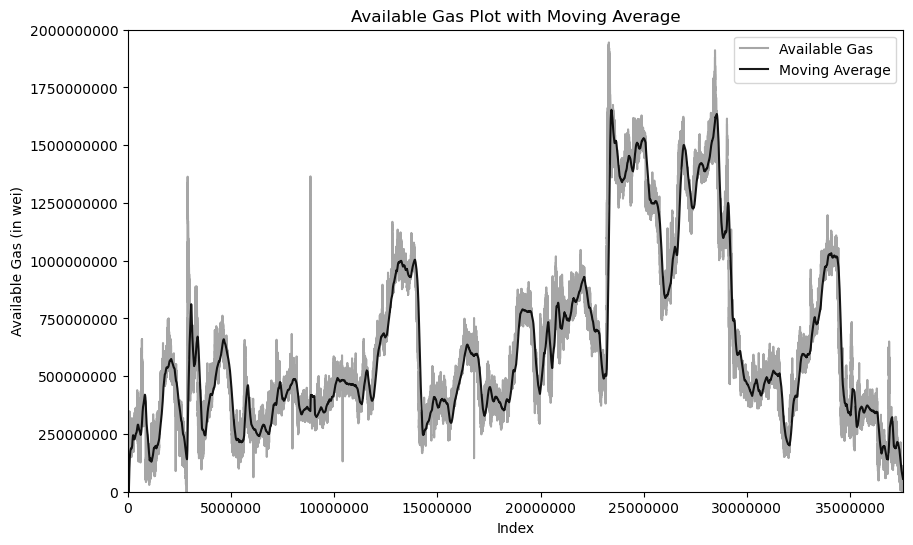

<Figure size 640x480 with 0 Axes>

In [10]:
# Plot the availible gas

# Moving Average
# SET window_size HERE for the moving average
window_size = 200000
df['rolling_mean_gas'] = df['avail_gas'].rolling(window=window_size, min_periods=1).mean()


# Plot the availible gas and moving average
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['avail_gas'], label='Available Gas', color='grey', alpha=.7)
plt.plot(df.index, df['rolling_mean_gas'], label='Moving Average', color = 'black', alpha=0.9)

plt.ticklabel_format(style='plain')

# set xlim and ylim
plt.xlim(0, df.shape[0])
plt.ylim(0, 2000000000)

plt.title('Available Gas Plot with Moving Average')
plt.xlabel('Index')
plt.ylabel('Available Gas (in wei)')

plt.legend()

plt.show()

# save the plot
plt.savefig("two_weeks_avail_gas_full_cycle_txns.png")

In [24]:
# Note there are some outliers in our data that fit the filters but are not actually full cycles. 
# These shouldn't effect the overall results much.

temp = df[df['hash'] == '0xead549c33288a32fa2277919efb79cc1715a80b4e4307cac1741987a4ecd849b']
print(temp[['detecttime', 'status', 'gas', 'avail_gas']])

                       detecttime     status         gas    avail_gas
7198     2023-08-26T00:03:23.057Z    evicted  16000000.0   -7187437.0
606823   2023-08-26T04:55:36.739Z    pending  16000000.0  179473996.0
847639   2023-08-26T06:54:42.803Z   rejected  16000000.0  225369446.0
2828335  2023-08-26T23:50:35.766Z  confirmed  16000000.0   56267747.0
